<a href="https://colab.research.google.com/github/ashjostan7/Sudoku/blob/main/PytorchDataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
#Imports
import torch
from torch import nn

In [45]:
#Device Agnostic code:
devcie = "cuda" if torch.cuda.is_available() else "cpu"

In [46]:
#Get Data:
import requests
import zipfile
from pathlib import Path


#Set up path to data folder:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#Check if image_path exists:
if image_path.is_dir():
  print(f"Image Path exists")
else:
  image_path.mkdir(parents= True, exist_ok=True)
  print(f"Image path does not exist")


with open(data_path/'pizza_steak_sushi.zip', "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading contens..")
  f.write(request.content)

with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
                     print("Unzipping Content")
                     zip_ref.extractall(image_path)


Image Path exists
Unzipping Content


Number of Images: 300
Random Image Path: data/pizza_steak_sushi/train/pizza/3281494.jpg
Image Classes: pizza_steak_sushi


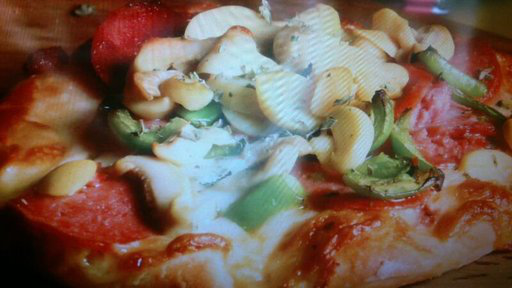

In [47]:
import random 
from PIL import Image

train_dir = image_path / 'train'
test_dir = image_path / 'test'

#Get Image Paths:
image_paths = list(image_path.glob('*/*/*.jpg'))
print(f"Number of Images: {len(image_paths)}")

#Random Image Path:
rndm_img_path = random.choice(image_paths)
print(f"Random Image Path: {rndm_img_path}")

#Image Classes:
image_classes = train_dir.parent.stem
print(f"Image Classes: {image_classes}")

#Open Image:
img = Image.open(rndm_img_path)
img



In [48]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize(size=[64,64]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
    ])

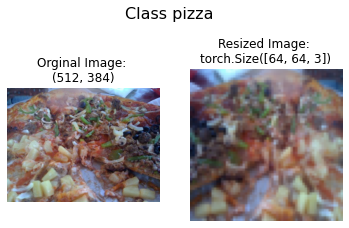

In [49]:
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for random_image_path in random_image_paths:
    with Image.open(random_image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Orginal Image: \n{f.size}")
      ax[0].axis("off")

      transformed_img = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_img)
      ax[1].set_title(f"Resized Image: \n{transformed_img.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class {random_image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_paths, data_transform, 1 )

In [50]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)
test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = data_transform, 
                                 target_transform = None)

print(f"Train Data {train_data}")
print(f"Test Data {test_data}")

Train Data Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [51]:
class_names = train_data.classes
print(f"Class Names: {class_names}")
class_dict = train_data.class_to_idx
print(f"Classes dictionary: {class_dict}")

Class Names: ['pizza', 'steak', 'sushi']
Classes dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}


In [52]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size= 1,
    num_workers = 1,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = 1,
    num_workers = 1,
    shuffle = False
)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f3b787b6520>,
 <torch.utils.data.dataloader.DataLoader at 0x7f3b8a3b6520>)

In [87]:
from typing import List, Dict, Tuple
import os

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

  if not classes:
    raise FileNotFoundError(f"File not found: {directory}")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [92]:
from torch.utils.data import Dataset

class ImageCustomeFolder(Dataset):

  def __init__(self, targ_dir:str, transform=None) -> None:

    self.paths = list(Path(targ_dir).glob("**/*.jpg"))
    self.transforms = transform
    self.classes, self.class_to_id = find_classes(targ_dir)
    #print(self.class_to_id)

  def load_image(self, index: int) -> Image.Image:

    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return (len(self.paths))
  
  def __getitem__(self, index: int)-> Tuple[torch.Tensor , int]:

    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_id[class_name]

    if self.transforms:
      return self.transforms(img), class_idx
    else:
      return img, class_idx

# Train/Test Custom Datatset and DataLoaders:


In [93]:
#Train:
train_transforms = transforms.Compose([
    transforms.Resize(size=[64,64]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

train_data_custom = ImageCustomeFolder(
    targ_dir = train_dir,
    transform = train_transforms 
)

train_dataloader_custom = DataLoader(
    dataset= train_data_custom,
    batch_size =1,
    num_workers = os.cpu_count(),
    shuffle= True
)
train_dataloader_custom

In [94]:
#Test:
test_transforms =transforms.Compose([
    transforms.Resize(size=[64,64]),
    transforms.ToTensor()
])
test_data_custom = ImageCustomeFolder(
    targ_dir = test_dir,
    transform = test_transforms 
)

test_dataloader_custom = DataLoader(
    dataset= test_data_custom,
    batch_size =1,
    num_workers = os.cpu_count(),
    shuffle= True
)
test_dataloader_custom

In [95]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [98]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [104]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  model.train() 
  train_acc , train_loss = 0,0

  for batch, (X,y) in enumerate(dataloader):
    
    X,y = X.to(device), y.to(device)

    #Forward Pass:
    y_pred = model(X)

    #Claculate Loss and Accuracy:
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    #Optimiser Zero Grad
    optimizer.zero_grad()

    #4. Backward Loss:
    loss.backward()

    #5. Optimiser Step:
    optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)


  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc






In [105]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [106]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_custom,
                        test_dataloader=test_dataloader_custom,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1182 | train_acc: 0.2844 | test_loss: 1.0964 | test_acc: 0.3467
Epoch: 2 | train_loss: 1.1018 | train_acc: 0.3156 | test_loss: 1.0964 | test_acc: 0.4400
Epoch: 3 | train_loss: 1.0707 | train_acc: 0.5289 | test_loss: 1.0315 | test_acc: 0.4667
Epoch: 4 | train_loss: 0.9858 | train_acc: 0.5422 | test_loss: 1.0120 | test_acc: 0.3733
Epoch: 5 | train_loss: 0.9025 | train_acc: 0.6089 | test_loss: 0.9865 | test_acc: 0.4667
Total training time: 18.303 seconds


In [107]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [108]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
